In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
from hmmlearn import hmm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [12]:
# Download historical data
ticker = "GC=F"
data = yf.download(ticker, start="2010-01-01", end="2025-03-01")
data = data[['Open', 'High', 'Low', 'Close']]

# Create features
data['Returns'] = data['Close'].pct_change() * 100  # Percentage returns
data['Volatility'] = data['Returns'].rolling(21, min_periods=1).std()  # Historical volatility
data.dropna(inplace=True)

[*********************100%***********************]  1 of 1 completed


In [13]:
"""Scale features using walk-forward method"""
# Initialize scaler with first observation
scaler = StandardScaler()
scaled_features = np.zeros((len(data), 2))

# Walk-forward scaling
for i in range(len(data)):
    if i < 21:  # Warm-up period for volatility
        scaled_features[i] = [0, 0]
        continue
        
    # Use only data up to current point for scaling
    current_data = data.iloc[:i+1]
    scaler.fit(current_data[['Returns', 'Volatility']])
    # Reshape the current observation to 2D array
    current_observation = data.iloc[i][['Returns', 'Volatility']].values.reshape(1, -1)
    scaled_features[i] = scaler.transform(current_observation)

features = pd.DataFrame(scaled_features, columns=['Returns', 'Volatility'], index=data.index)

In [14]:
# Split into train/test (2010-2024 train, 2024-2025 test)
train_mask = features.index < '2024-01-01'
test_mask = features.index >= '2024-01-01'

In [20]:
"""Train HMM with multiple initializations"""
best_model = None
best_score = -np.inf
n_states = 3

# Multiple initializations to avoid local maxima
for _ in range(10):
    model = hmm.GaussianHMM(
        n_components=n_states,
        covariance_type="full",
        n_iter=1000,
        implementation="log",
        random_state=np.random.randint(0, 1000)
    )
    model.fit(features[train_mask])
    score = model.score(features[train_mask])
    if score > best_score:
        best_score = score
        best_model = model

In [21]:
# Predict on entire dataset (test predictions are out-of-sample)
hidden_states = model.predict(features)
data['Regime'] = hidden_states

C:\Users\najdu\AppData\Local\Temp\ipykernel_6192\1339529631.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', model.n_components)


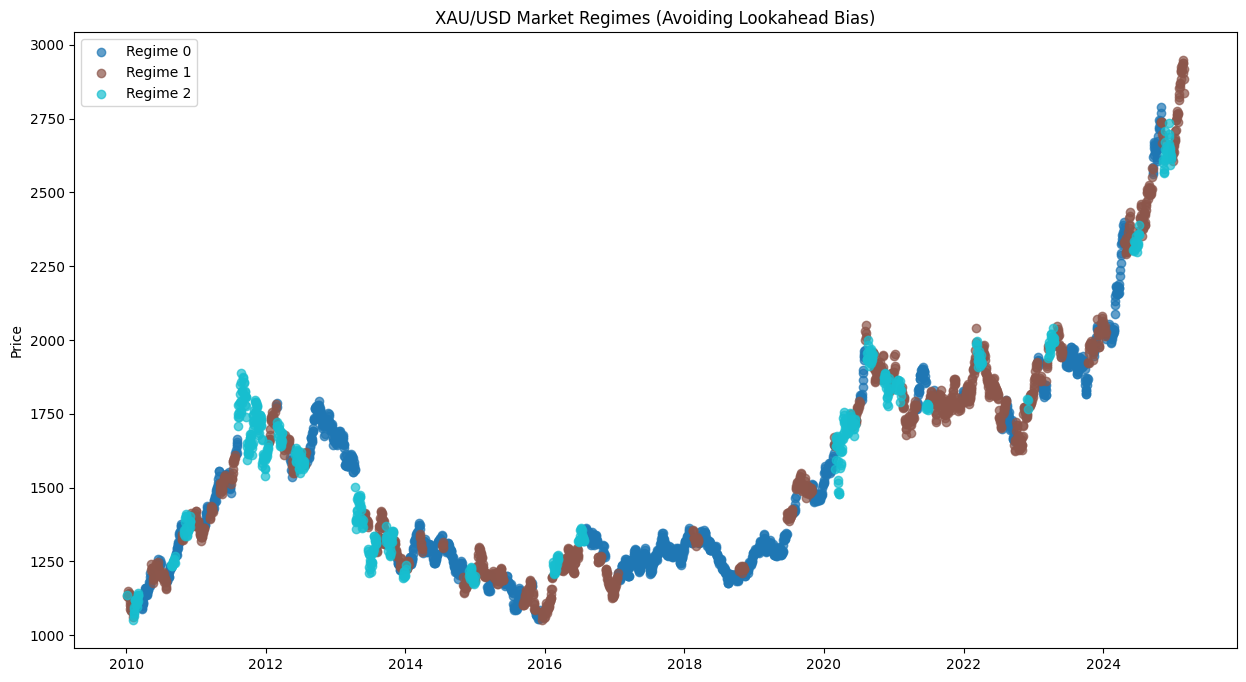

Regime Characteristics (Train Period 2010-2024):

Regime 0:
Average Return: 0.0279%
Average Volatility: 0.6949%
Duration: 46.3%

Regime 1:
Average Return: 0.0260%
Average Volatility: 0.9902%
Duration: 37.2%

Regime 2:
Average Return: -0.0005%
Average Volatility: 1.5526%
Duration: 16.4%

Test Set Results (2024-2025):

Regime 0 occurred 98 times
Test Period Returns: 0.2540%

Regime 1 occurred 142 times
Test Period Returns: 0.0768%

Regime 2 occurred 52 times
Test Period Returns: -0.0503%


In [22]:
# Plot results
plt.figure(figsize=(15, 8))
# Dynamically generate colors based on number of regimes
colors = plt.cm.get_cmap('tab10', model.n_components)

for i in range(model.n_components):
    mask = data['Regime'] == i
    plt.scatter(data.index[mask], data['Close'][mask], 
                c=[colors(i)], label=f'Regime {i}', alpha=0.7)

plt.title('XAU/USD Market Regimes (Avoiding Lookahead Bias)')
plt.ylabel('Price')
plt.legend()
plt.show()

# Print regime statistics (train set only for parameters)
print("Regime Characteristics (Train Period 2010-2024):")
train_data = data[train_mask]
for i in range(model.n_components):
    regime_data = train_data[train_data['Regime'] == i]
    print(f"\nRegime {i}:")
    print(f"Average Return: {regime_data['Returns'].mean():.4f}%")
    print(f"Average Volatility: {regime_data['Volatility'].mean():.4f}%")
    print(f"Duration: {len(regime_data)/len(train_data):.1%}")

# Test set evaluation
print("\nTest Set Results (2024-2025):")
test_data = data[test_mask]
for i in range(model.n_components):
    regime_data = test_data[test_data['Regime'] == i]
    print(f"\nRegime {i} occurred {len(regime_data)} times")
    print(f"Test Period Returns: {regime_data['Returns'].mean():.4f}%")